# Dynamic Models for Building Energy Management - Report

Authors: Emile HEYBERGER, Félix LABIDI, Perrine MEZIAT-BURDIN, Quentin SAMUDIO

Date: 30/05/2022

The notebooks can be run interactively on MyBinder.com by clicking on the button below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/heyberge/Smart-Cities/HEAD)

## Introduction 

In this lab, we worked on the thermal modelling of a building. We imagined the building and its thermal characteristics, then built its thermal network. We computed the matrices that were needed for the mathematical model, and then conducted two analyses : one in steady state and a dynamic one. Then we simulated the response to weather data and worked on the optimization of our model. 


## Contents 


    1) Description of the building
    2) Thermal model 
    3) Elements of the thermal network
    4) Mathematical model
    5) Steady State Model
    6) Dynamic Model
    7) Response to weather data
    8) Conclusion : optimization

    


## 1) Description of the building: 

-	 Drawing, dimensions and materials

Our thermal study focuses on a student flat in a residence in Lyon. We simplify the flat as a 2-room flat: a living room of about 25 m2 and a bathroom of 6 m2.

The plan and the model for our appartement are the following :

<img src="plan.png" width="400"> <img src="surface.png" width="400">


Each external wall are made of concrete and glass wool, while the wall separating the two rooms is made of plasterboard. The wall Sm1 is in contact with the outside, Smc with a corridor heated at 20°C and Sm3 with another appartement, but this wall is considered as perfectly isolated. Sf and Sp are respectively the windows and the doors. 

The following table gives the dimensions and features: 

<img src="Caracteristiques.png" width="600">

-	Hypothesis

To simplify the octave modeling, the following assumptions are made: 

- The temperature is uniform on each surface of a wall;
- Heat transfer is unidirectional in each wall ;
- Heat transfers with the floor and ceiling are neglected ;
- Heat transfers are assumed to be linear;
- The heat flows coming from the neighboring apartment is considered negligible;



## 2) Thermal model

We following scheme shows the thermal model we finally came up with: 

<img src="schema_maison.png" width="900">

Nodes 0 and 1 are respectively representing the main room and the bathroom. The chains of resistances (for conduction and convection) and capacities represent the thermal flux through the walls, doors and windows. We also represent the solar indoor and outdoor flux by radiation, and the temperature sources of the corridor (Tcouloir) and the outside (Text). A proportional corrector is represented by a resistance linked to a targeted temperature (Tcible). 

We also number the nodes and resistances and the direction of the flux. 

## 3) Elements of the thermal network


The thermal resistances for conduction are of the form:
$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².

The thermal capacities of the wall are of the form:
$$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$$

The thermal capacity of the air is:
$$C_{air} = \rho_{air} c_{air} V_{air}$$




## 4) Mathematical model

Using the previous formulas, we compute all the values of the thermal resistances (and associated conductances), and capacities. We can then implement the matrices A, G, C, b and f. We also implement a vector u, that is a concatenation of all the non-zero values of b and f. 




In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

Text, Tcouloir=5, 20
Tcible=22

Gab,Gb,Gi ,Gia =250,275,8.75, 100
Gap,Gp,Gpa=10,2.5E+01,10
Gav,Gv,Gva=20,8.00E+02,8
Gaplaco ,Gplaco ,Gplacoa =50,4.81E+02,50
Gab2,Gb2,Gi2,Gia2=40,44,1.4,16
Gabc,Gbc,Gic,Giac=50,137.5,4.375,50




### Matrice A

In [16]:
A=np.zeros((39,32))
A[30,0],A[31,0],A[32,0],A[33,0],A[34,1],A[35,1],A[36,1],A[37,1]=1,1,1,1,1,1,1,1
A[16,0],A[27,0]=-1,-1
I=[[0,2],[1,3],[2,4],[3,5],[5,6],[6,7],[7,8],[8,9],[10,10],[11,11],[13,12],[14,13],[16,14],[17,15],[19,16],[20,17],[22,18],[23,19],[24,20],[25,21],[27,22],[28,23]]
A[4,24],A[9,25],A[15,27],A[18,28],A[21,29],A[26,30],A[29,31]=1,1,1,1,1,1,1
A[38,0]=1

i=0
for k in range(8):
    A[30+i,24+i]=-1
    i=i+1
    
for k in range(len(I)):

    A[I[k][0],I[k][1]]=1
    A[I[k][0]+1,I[k][1]]=-1
    
print("A=",np.array(A))

A= [[ 0.  0.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  1.  0. ...  0. -1.  0.]
 [ 0.  1.  0. ...  0.  0. -1.]
 [ 1.  0.  0. ...  0.  0.  0.]]


### MATRICE G

In [27]:

Kp=1e-5
Gdiag=[Gab ,Gb ,Gb ,Gi ,Gi ,Gabc,Gbc,Gbc,Gic,Gic,Gav,Gv,Gva,Gap,Gp,Gp,Gaplaco ,Gplaco ,Gplaco ,Gav,Gv,Gv,Gab2,Gb2,Gb2,Gi2,Gi2,Gap,Gp,Gp,Gia, Giac, Gva,Gpa,Gplacoa, Gva,Gia2,Gpa, Kp]
G=np.zeros((len(Gdiag),len(Gdiag)))


for k in range(len(Gdiag)):
     G[k,k]=Gdiag[k]
     
print("G=",G) 


G= [[2.50e+02 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 2.75e+02 0.00e+00 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 2.75e+02 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 1.60e+01 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 1.00e+01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 0.00e+00 0.00e+00 1.00e-05]]


### MATRICE b


In [28]:
b=np.zeros(39)
ind=[0,5,10,13,19,22,38]
tb=[Text,Tcouloir,Text,Tcouloir,Text,Text,Tcible]

for k in range(len(ind)):
     b[ind[k]]=tb[k]
     
print("b=",b)         


b= [ 5.  0.  0.  0.  0. 20.  0.  0.  0.  0.  5.  0.  0. 20.  0.  0.  0.  0.
  0.  5.  0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 22.]


### MATRICE f


In [1]:
ft=[1,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1]

f=np.zeros(32)
for k in range(19):
    f[k]=ft[k]
    

print("f=",f)

NameError: name 'np' is not defined

### MATRICE C



In [30]:
c3,c5,c7,c9,c11,c13,c15,c17,c19,c21,c23=12960000,105000,3.22E+05,3.22E+05,2.00E+04,2.00E+04,1.61E+05,2073600,16800,6480000,52500

C=np.zeros((32,32))
Cval=[c3,c5,c7,c9,c11,c13,c15,c17,c19,c21,c23]
for k in range(len(Cval)):
    C[3+2*k,3+2*k]=Cval[k]

print("C=",C)


C= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### VECTEUR u



In [31]:
y = np.ones(32)
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])
print("u=",u)

u= [   5.   20.    5.   20.    5.    5.   22. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]



## 5) Steady State Model

### Model implementation in Python

We implemente the steady state model as following : 

 



In [32]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

# print('Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :')
# print(np.array_str(yss, precision=3, suppress_small=True))
# print('\n Temperatures at the different nodes obtained with the state space:')
# print(np.array_str(ytc, precision=3, suppress_small=True))
# print(f'\n Max error in steady-state between thermal circuit and state-space:\
#   {max(abs(yss - ytc)):.2e}')




### Steady-state results


- Result for kp = 1e-5:

In [33]:
 Kp=1e-5
Gdiag=[Gab ,Gb ,Gb ,Gi ,Gi ,Gabc,Gbc,Gbc,Gic,Gic,Gav,Gv,Gva,Gap,Gp,Gp,Gaplaco ,Gplaco ,Gplaco ,Gav,Gv,Gv,Gab2,Gb2,Gb2,Gi2,Gi2,Gap,Gp,Gp,Gia, Giac, Gva,Gpa,Gplacoa, Gva,Gia2,Gpa, Kp]
G=np.zeros((len(Gdiag),len(Gdiag)))


for k in range(len(Gdiag)):
     G[k,k]=Gdiag[k]
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print('Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :')
print(np.array_str(yss, precision=3, suppress_small=True))
print('\n Temperatures at the different nodes obtained with the state space:')
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'\n Max error in steady-state between thermal circuit and state-space:\{max(abs(yss - ytc)):.2e}')

Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :
[179.235 185.529  11.725  14.203  16.681  94.551  45.442  47.421  49.4
 111.596  39.397  39.007 141.155 149.617 182.085 182.382  91.769  92.688
  32.49   34.754  37.017 108.161 181.483 182.382 172.421 173.792 179.235
 158.079 182.678  93.607 179.304 183.281]

 Temperatures at the different nodes obtained with the state space:
[179.235 185.529  11.725  14.203  16.681  94.551  45.442  47.421  49.4
 111.596  39.397  39.007 141.155 149.617 182.085 182.382  91.769  92.688
  32.49   34.754  37.017 108.161 181.483 182.382 172.421 173.792 179.235
 158.079 182.678  93.607 179.304 183.281]

 Max error in steady-state between thermal circuit and state-space:\2.39e-12


- Result for kp=100:

In [34]:
Kp=100
Gdiag=[Gab ,Gb ,Gb ,Gi ,Gi ,Gabc,Gbc,Gbc,Gic,Gic,Gav,Gv,Gva,Gap,Gp,Gp,Gaplaco ,Gplaco ,Gplaco ,Gav,Gv,Gv,Gab2,Gb2,Gb2,Gi2,Gi2,Gap,Gp,Gp,Gia, Giac, Gva,Gpa,Gplacoa, Gva,Gia2,Gpa, Kp]
G=np.zeros((len(Gdiag),len(Gdiag)))


for k in range(len(Gdiag)):
     G[k,k]=Gdiag[k]
        
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print('Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :')
print(np.array_str(yss, precision=3, suppress_small=True))
print('\n Temperatures at the different nodes obtained with the state space:')
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'\n Max error in steady-state between thermal circuit and state-space:\{max(abs(yss - ytc)):.2e}')

Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :
[42.021 74.812  9.529 10.009 10.49  25.594 40.079 40.108 40.136 41.039
 39.397 39.007 92.15  81.01  56.872 58.416 60.581 60.72  30.717 31.37
 32.022 52.52  53.732 58.416 40.699 41.942 42.021 69.87  59.96  60.86
 73.018 63.101]

 Temperatures at the different nodes obtained with the state space:
[42.021 74.812  9.529 10.009 10.49  25.594 40.079 40.108 40.136 41.039
 39.397 39.007 92.15  81.01  56.872 58.416 60.581 60.72  30.717 31.37
 32.022 52.52  53.732 58.416 40.699 41.942 42.021 69.87  59.96  60.86
 73.018 63.101]

 Max error in steady-state between thermal circuit and state-space:\6.54e-13


- Results for kp=1e6

In [35]:
Kp=1e6
Gdiag=[Gab ,Gb ,Gb ,Gi ,Gi ,Gabc,Gbc,Gbc,Gic,Gic,Gav,Gv,Gva,Gap,Gp,Gp,Gaplaco ,Gplaco ,Gplaco ,Gav,Gv,Gv,Gab2,Gb2,Gb2,Gi2,Gi2,Gap,Gp,Gp,Gia, Giac, Gva,Gpa,Gplacoa, Gva,Gia2,Gpa, Kp]
G=np.zeros((len(Gdiag),len(Gdiag)))


for k in range(len(Gdiag)):
     G[k,k]=Gdiag[k]
        
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print('Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :')
print(np.array_str(yss, precision=3, suppress_small=True))
print('\n Temperatures at the different nodes obtained with the state space:')
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'\n Max error in steady-state between thermal circuit and state-space:\{max(abs(yss - ytc)):.2e}')

Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :
[22.002 58.659  9.208  9.397  9.587 15.534 39.297 39.041 38.785 30.745
 39.397 39.007 85.001 71.001 38.605 40.33  56.031 56.056 30.459 30.876
 31.293 44.402 35.094 40.33  21.482 22.706 22.002 57.001 42.056 56.082
 57.512 45.567]

 Temperatures at the different nodes obtained with the state space:
[22.002 58.659  9.208  9.397  9.587 15.534 39.297 39.041 38.785 30.745
 39.397 39.007 85.001 71.001 38.605 40.33  56.031 56.056 30.459 30.876
 31.293 44.402 35.094 40.33  21.482 22.706 22.002 57.001 42.056 56.082
 57.512 45.567]

 Max error in steady-state between thermal circuit and state-space:\6.04e-13


1e6 is the limit for which the temperature at node 0 reaches the target temperature. 

- Results for kp=1e4:

In [36]:
Kp=1e4
Gdiag=[Gab ,Gb ,Gb ,Gi ,Gi ,Gabc,Gbc,Gbc,Gic,Gic,Gav,Gv,Gva,Gap,Gp,Gp,Gaplaco ,Gplaco ,Gplaco ,Gav,Gv,Gv,Gab2,Gb2,Gb2,Gi2,Gi2,Gap,Gp,Gp,Gia, Giac, Gva,Gpa,Gplacoa, Gva,Gia2,Gpa, Kp]
G=np.zeros((len(Gdiag),len(Gdiag)))


for k in range(len(Gdiag)):
     G[k,k]=Gdiag[k]
        
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print('Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :')
print(np.array_str(yss, precision=3, suppress_small=True))
print('\n Temperatures at the different nodes obtained with the state space:')
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'\n Max error in steady-state between thermal circuit and state-space:\{max(abs(yss - ytc)):.2e}')

Temperatures at the different nodes obtained with the differential-algebraic equations of the thermal circuit :
[22.229 58.842  9.212  9.404  9.597 15.648 39.305 39.053 38.8   30.862
 39.397 39.007 85.082 71.115 38.812 40.535 56.082 56.109 30.462 30.882
 31.301 44.494 35.305 40.535 21.7   22.924 22.229 57.147 42.259 56.136
 57.687 45.766]

 Temperatures at the different nodes obtained with the state space:
[22.229 58.842  9.212  9.404  9.597 15.648 39.305 39.053 38.8   30.862
 39.397 39.007 85.082 71.115 38.812 40.535 56.082 56.109 30.462 30.882
 31.301 44.494 35.305 40.535 21.7   22.924 22.229 57.147 42.259 56.136
 57.687 45.766]

 Max error in steady-state between thermal circuit and state-space:\6.18e-13


This value of Kp is the one that will be kept for the following analyses. Indeed, the difference at the target temperature remains minimal (we reach 21.984°C, which is satisfactory), and we limit the value of the gain.
 At node 1 (bathroom), the temperature reached is 18.7°C


We also note the very small difference between the two models in all the different cases.


## 6) Dynamic Model

### Implementation in Python

We implemente the dynamic model as following : 




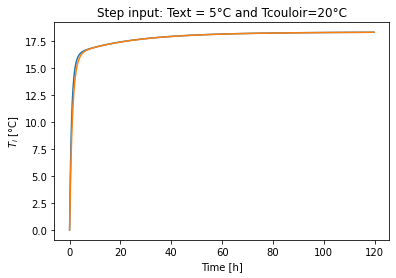

In [37]:
#we build a new vector y, which allows to isolate only the temperature at one node
y = np.zeros(32)
node_wanted = 1
y[node_wanted] = 1
# then we must recalculate the matrixes of the state space system, as they depend on y
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)


dtmax = min(-2. / np.linalg.eig(As)[0])  # we obtain dtmax=1453.9
dt = 1000 # we take dt<dtmax
duration = 3600 * 24 * 5 
n = int(np.floor(duration / dt))
t = np.arange(0, n * dt, dt)    # time
n_tC = As.shape[0]              # no of state variables 

u = np.ones([15, n])
u[0:1, :] = Text*np.ones([1, n])
u[1:2, :] = Tcouloir*np.ones([1, n])
u[2:3, :] = Text*np.ones([1, n])
u[3:4, :] = Tcouloir*np.ones([1, n])
u[4:5, :] = Text*np.ones([1, n])
u[5:6, :] = Text*np.ones([1, n])
u[6:7, :] = Tcible*np.ones([1, n])

temp_exp = np.zeros([n_tC, t.shape[0]]) #Euler forward 
temp_imp = np.zeros([n_tC, t.shape[0]]) #Euler backward

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u


fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
        ylabel='$T_i$ [°C]',
        title='Step input: Text = 5°C and Tcouloir=20°C')
plt.show()



### Results

The following graph shows the evolution of the temperature at node 0 (main room): 

<img src="dynamic.png" width="500">

We arrive at the target temperature of 22°C (with the same deviation as observed earlier, due to the limitation of the value of Kp to 1e4)
There is very little difference between the solution with implicit Euler and the one with explicit Euler (the two curves are almost superimposed). 

The following graph shows the evolution of the temperature at node 1 (bathroom): it stabilises at 18.3°C. 

<img src="dynamic_N1.png" width="500">

## 7) Response to weather data

### Implementation in Python

We implement a last version of the model, taking into account the variations of the weather. 



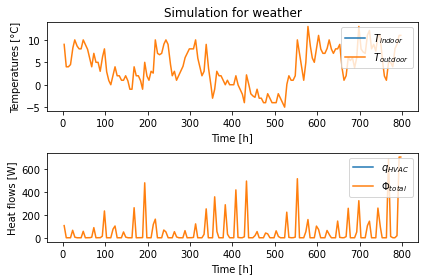

In [50]:
## Weather data

filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'


[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (weather.index < end_date)]


surface_orientation = {'slope': 90,'azimuth': 0,'latitude': 45}
albedo = 0.3 #concrete 
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)
##
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'Text'})

data['Tcible'] = Tcible * np.ones(data.shape[0])
data['Tcouloir'] = Tcouloir * np.ones(data.shape[0])


t = dt * np.arange(data.shape[0])

ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity
Sm1 = 25
Sf = 2

phi_out= α_wSW * Sm1 * data['Φt1']       
phi_in=τ_gSW * α_wSW * Sf * data['Φt1']

u = pd.concat([data['Text'],data['Tcouloir'], data['Text'],data['Tcouloir'], data['Text'],data['Text'], data['Tcible'],phi_in,phi_in,phi_out,phi_out,phi_out,phi_out,phi_out,phi_out], axis=1)

temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
            + dt * Bs @ u.iloc[k, :]
##
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Tcible'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['Text'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
ylabel='Temperatures [°C]',
title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600, q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()



### Results

Here are the curves be obtained : 

<img src="weather.png" width="500">

There must be a problem with the code, as the curves of indoor and outdoor temperatures should not be the same. 



## 8) Conclusion : optimization 

As a conclusion, we can say that this lab allowed us to understand and practise the thermal modeling of buildings. The model we built, however, isn’t perfect. We could have optimized it by adding a second controller in the bathroom, with a second targeted temperature. It would also have been interesting to compare with other materials and thicknesses. 


